記述統計へのDP適用

In [2]:
!pip install ja-ginza

## 1. 必要なライブラリのインストール

In [3]:
!pip install spacy
!pip install sklearn
!pip install python-dp

  Using cached sklearn-0.0.post12.tar.gz (2.6 kB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... error
  error: subprocess-exited-with-error
  
  × Getting requirements to build wheel did not run successfully.
  │ exit code: 1
  ╰─> [15 lines of output]
      The 'sklearn' PyPI package is deprecated, use 'scikit-learn'
      rather than 'sklearn' for pip commands.
      
      Here is how to fix this error in the main use cases:
      - use 'pip install scikit-learn' rather than 'pip install sklearn'
      - replace 'sklearn' by 'scikit-learn' in your pip requirements files
        (requirements.txt, setup.py, setup.cfg, Pipfile, etc ...)
      - if the 'sklearn' package is used by one of your dependencies,
        it would be great if you take some time to track which package uses
        'sklearn' instead of 'scikit-learn' and report it to their issue tracker
      - as a last resort, set the environment variable
        SKLEARN_ALLOW_DEPRECATED_SK

## 2. データの読み込みと形態素解析


In [4]:
import pandas as pd

data_path = './data/reviews_with_sentiment.csv'

df = pd.read_csv(data_path)
df

,review,sentiment
0,出張でお世話になりました。,neutral
1,朝食は普通でした。,neutral
2,また是非行きたいです。,positive
3,また利用したいと思えるホテルでした。,positive
4,駅から近くて便利でした。,positive
...,...,...
5548,スクランブルエッグにとても大きな殻が入っていてざりざりして気持ちが悪く未だに思い出します。,negative
5549,何組か食事してましたが、明らかにレストランではないスペース。,negative
5550,静かで居心地も良いしまた行きたい宿になりましたが、一点だけ残念だったのが夕食の海鮮舟盛りです。,neutral
5551,チェックインして、部屋に入るとベッドルームの照明の位置もわかりにくく、大変な思いをしました。,negative


In [5]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
import spacy
import itertools
from typing import List, Tuple
from pydp.algorithms.laplacian import Count
import math

# spaCyの日本語モデルのロード
nlp = spacy.load('ja_ginza')



# データの読み込み
data_path = './data/reviews_with_sentiment.csv'
df = pd.read_csv(data_path)

# 抽出する品詞の指定
POS = ['ADJ', 'ADV', 'INTJ', 'PROPN', 'NOUN', 'VERB']
MAX_TERMS_IN_DOC = 5
NGRAM = 1
MAX_DF = 1.0
MIN_DF = 0.0
NUM_VOCAB = 10000
TOP_K = 20

def flatten(*lists) -> list:
    res = []
    for l in list(itertools.chain.from_iterable(lists)):
        for e in l:
            res.append(e)
    return res

def remove_duplicates(l: List[Tuple[str, float]]) -> List[Tuple[str, float]]:
    d = {}
    for e in l:
        d[e[0]] = e[1]
    return list(d.items())

def preprocess_for_private_counts(tf: np.ndarray) -> List[np.ndarray]:
    repeated_words = []
    for i, term in enumerate(tf):
        repeated_words.append(np.repeat(i, term))
    return repeated_words

def cal_private_count(epsilon: float, max_partition_contributed: float, max_contributions_per_partition: float, repeated_words: List[np.ndarray]) -> List[int]:
    private_counts = []
    for repeated_word in repeated_words:
        counter = Count(epsilon, max_partition_contributed, max_contributions_per_partition)
        count = counter.quick_result(repeated_word)
        private_counts.append(count)
    return private_counts

def top_k_words_and_counts(k: int, tf: np.ndarray, vocab: dict) -> List[Tuple[str, int]]:
    indices_topk = np.argsort(tf)[::-1][:k]
    reverse_vocab = {vocab[key]: key for key in vocab.keys()}
    words = [reverse_vocab[i] for i in indices_topk]
    counts = [tf[i] for i in indices_topk]
    return list(zip(words, counts))
# 形態素解析
df["doc"] = [nlp(review) for review in df["review"]]

/home/jun/.pyenv/versions/3.11.8/lib/python3.11/site-packages/torch/cuda/__init__.py:118: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


## 3. Bag-of-Wordsの生成

In [6]:
# Bag-of-Wordsの生成
bows = {}
cvs = {}

for sentiment in df["sentiment"].unique():
    tokens = []
    for doc in df[df["sentiment"] == sentiment]["doc"]:
        similarities = [(token.similarity(doc), token.lemma_) for token in doc if token.pos_ in POS]
        similarities = remove_duplicates(similarities)
        similarities = sorted(similarities, key=lambda sim: sim[1], reverse=True)[:MAX_TERMS_IN_DOC]
        tokens.append([similarity[1] for similarity in similarities])
    
    cv = CountVectorizer(ngram_range=(1, NGRAM), max_df=MAX_DF, min_df=MIN_DF, max_features=NUM_VOCAB)
    bows[sentiment] = cv.fit_transform(flatten(tokens)).toarray()
    cvs[sentiment] = cv

/tmp/ipykernel_1207722/2647833454.py:8: UserWarning: [W008] Evaluating Token.similarity based on empty vectors.
  similarities = [(token.similarity(doc), token.lemma_) for token in doc if token.pos_ in POS]


In [7]:
!pip install numpy


## 4. 上位単語の頻度を計算

In [8]:
# 上位単語の頻度を計算
vocabs = {}
term_frequencies = {}

for sentiment in df["sentiment"].unique():
    bow = bows[sentiment]
    cv = cvs[sentiment]
    
    vocab = cv.vocabulary_
    term_frequency = np.sum(bow, axis=0)
    vocabs[sentiment] = vocab
    term_frequencies[sentiment] = term_frequency
    
    indices_topk = np.argsort(term_frequency)[::-1][:TOP_K]
    bow_topk = np.take(bow, indices_topk, axis=1)
    reverse_vocab = {vocab[k]: k for k in vocab.keys()}
    words = [reverse_vocab[i] for i in indices_topk]
    
    print(sentiment, ":")
    for w, c in zip(words, term_frequency[indices_topk]):
        print(w, ":", c)


neutral :
利用 : 216
部屋 : 93
旅行 : 67
ある : 60
思う : 59
朝食 : 50
風呂 : 47
普通 : 45
宿泊 : 43
なる : 43
初めて : 34
ホテル : 32
いる : 30
良い : 27
感じ : 27
家族 : 25
出張 : 25
予約 : 23
する : 22
夕食 : 21
positive :
良い : 463
部屋 : 315
美味しい : 206
利用 : 198
満足 : 193
朝食 : 181
思う : 175
ある : 144
風呂 : 141
最高 : 140
ホテル : 124
対応 : 106
いる : 102
また : 99
温泉 : 96
清潔 : 90
よい : 90
接客 : 87
綺麗 : 84
気持ち : 80
negative :
残念 : 99
部屋 : 97
少し : 48
風呂 : 42
朝食 : 39
狭い : 36
思う : 34
ある : 33
ない : 27
良い : 24
なる : 22
悪い : 19
欲しい : 16
する : 16
露天風呂 : 16
古い : 16
掃除 : 15
食べる : 15
食事 : 15
改善 : 14


## 5. 差分プライバシーの適用


In [9]:
# 差分プライバシーの適用
epsilons = [0.01, 0.05, 0.1, 0.3, 0.7, 1.0, 2.0, 3.0, 7.0, 10.0]
MAX_DUPLICATED_TERMS = 1

# 結果を保存するための辞書を初期化
results = {sentiment: {"no DP": None, **{eps: None for eps in epsilons}} for sentiment in df["sentiment"].unique()}

for eps in epsilons:
    print("ε: ", eps)
    for sentiment in df["sentiment"].unique():
        repeated_words = preprocess_for_private_counts(term_frequencies[sentiment])
        private_counts = cal_private_count(eps, MAX_TERMS_IN_DOC, MAX_DUPLICATED_TERMS, repeated_words)
        
        words_and_counts = top_k_words_and_counts(TOP_K, private_counts, vocabs[sentiment])
        results[sentiment][eps] = words_and_counts
        print(sentiment, ":")
        print(words_and_counts)



ε:  0.01
neutral :
[('最上階', 3495), ('申し訳', 3107), ('非常口', 3046), ('変わり', 2706), ('提供', 2686), ('建築物', 2471), ('驚く', 2470), ('土産', 2345), ('クロワッサン', 2302), ('地球', 2284), ('エコ', 2196), ('季節', 2164), ('フロント', 2120), ('周年', 2103), ('建て', 2077), ('酷い', 2033), ('経験', 1979), ('マラソン', 1963), ('揃う', 1922), ('お遍路', 1851)]
positive :
[('寝心地', 3492), ('母親', 2935), ('指定', 2771), ('門司港', 2738), ('予定', 2612), ('特筆', 2300), ('しっかり', 2257), ('麦茶', 2257), ('残念', 2251), ('言動', 2245), ('男子', 2184), ('小鉢', 2170), ('我が家', 2068), ('施術', 2032), ('日和', 2030), ('負ける', 1983), ('コラボ', 1958), ('考慮', 1915), ('たいへん', 1831), ('連休', 1825)]
negative :
[('容器', 3298), ('物凄い', 3286), ('落ちる', 3132), ('深い', 3062), ('薄める', 2874), ('アイロン', 2389), ('設備', 2169), ('レバー', 2169), ('大名', 2154), ('フロント', 2148), ('取り付ける', 1912), ('空室', 1898), ('ゆっくり', 1863), ('依頼', 1839), ('ハーブ', 1821), ('飛騨', 1818), ('眺め', 1802), ('開け閉め', 1724), ('スーツケース', 1704), ('明らか', 1695)]
ε:  0.05
neutral :
[('場合', 675), ('自家製', 607), ('んー', 526), ('終電', 514),

## 6. 結果を表形式で表示


In [15]:
# 差分プライバシーなしの頻度計算を保存
for sentiment in df["sentiment"].unique():
    words_and_counts = top_k_words_and_counts(TOP_K, term_frequencies[sentiment], vocabs[sentiment])
    results[sentiment]["no DP"] = words_and_counts

# 結果を表示する関数
def display_results(results):
    for sentiment, data in results.items():
        print(f"\nSentiment: {sentiment}\n")
        df = pd.DataFrame(columns=["rank", "word"] + [f"ε={eps}" for eps in epsilons])
        for rank, (word, count) in enumerate(data["no DP"], start=1):
            row = {"rank": rank, "word": word, "count": count}
            for eps in epsilons:
                if eps in data and rank <= len(data[eps]):
                    row[f"ε={eps}"] = data[eps][rank-1][1] if rank-1 < len(data[eps]) else None
            df = pd.concat([df, pd.DataFrame([row])], ignore_index=True)
        print(df)

display_results(results)


Sentiment: neutral

   rank word ε=0.01 ε=0.05 ε=0.1 ε=0.3 ε=0.7 ε=1.0 ε=2.0 ε=3.0 ε=7.0 ε=10.0  \
0     1   利用   3495    675   296   200   213   209   215   217   216    217   
1     2   部屋   3107    607   266   106    80    97    93    86    93     93   
2     3   旅行   3046    526   259    96    62    66    63    68    67     69   
3     4   ある   2706    514   256    95    57    64    59    60    59     60   
4     5   思う   2686    490   255    93    55    57    57    57    55     59   
5     6   朝食   2471    460   242    91    55    55    49    51    48     50   
6     7   風呂   2470    418   224    89    48    51    48    46    48     48   
7     8   普通   2345    417   216    81    47    43    46    44    45     45   
8     9   宿泊   2302    410   209    78    45    37    45    42    42     43   
9    10   なる   2284    406   207    77    43    34    44    42    42     42   
10   11  初めて   2196    398   207    72    41    33    38    37    33     33   
11   12  ホテル   2164    392   20

## 7.グラフの生成

In [11]:
!pip install matplotlib
!pip install seaborn

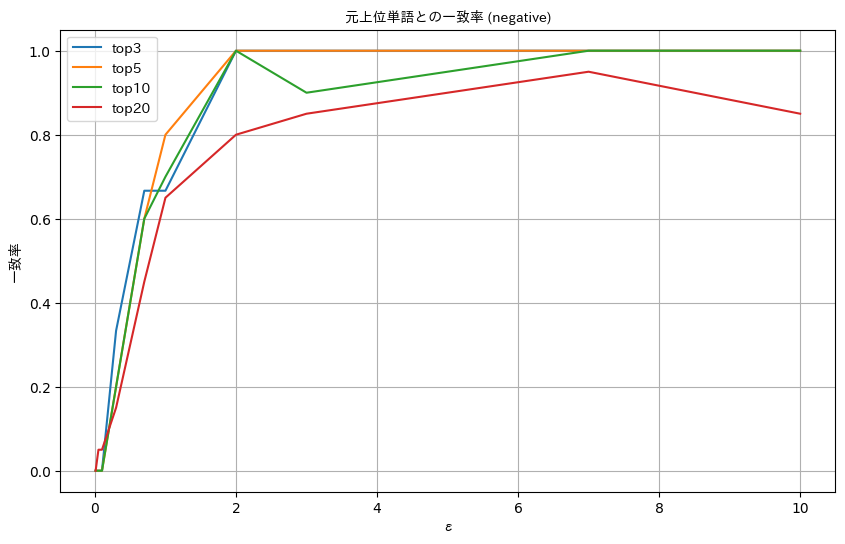

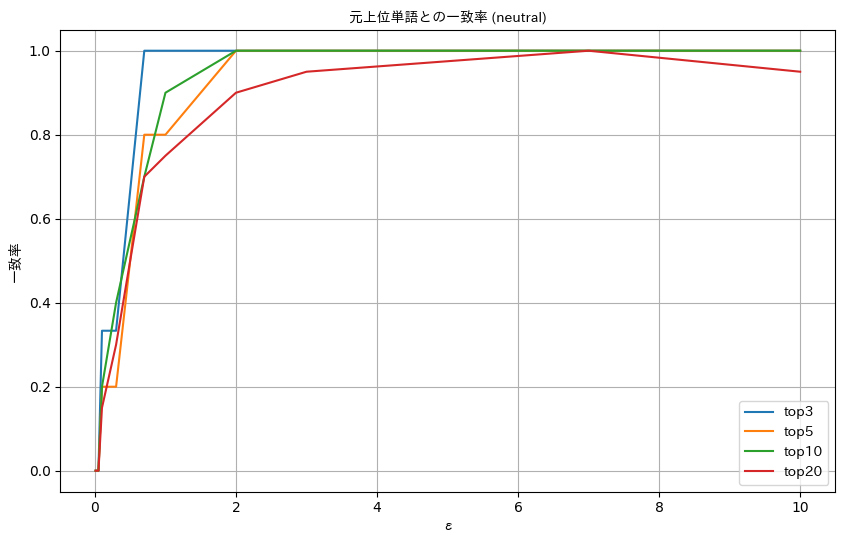

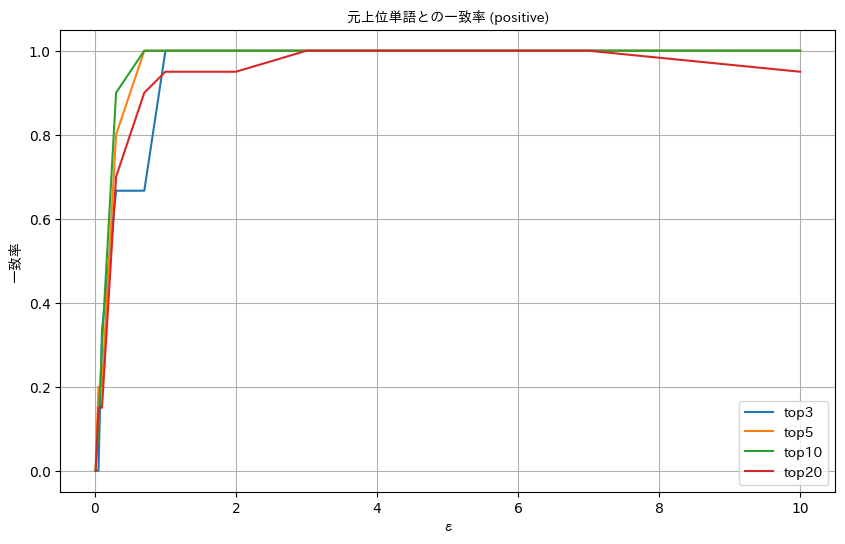

In [12]:
# グラフの生成
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# 日本語フォントの設定
font_path = '/usr/share/fonts/truetype/fonts-japanese-gothic.ttf'  # フォントパスを指定
font_prop = fm.FontProperties(fname=font_path)

def calculate_match_rate(original_top_k, dp_top_k):
    match_count = len(set(original_top_k) & set(dp_top_k))
    return match_count / len(original_top_k) if original_top_k else 0

def plot_match_rate(results, epsilons, sentiment_label):
    top_k_values = [3, 5, 10, 20]
    match_rates = {k: [] for k in top_k_values}

    for eps in epsilons:
        for k in top_k_values:
            original_top_k = [word for word, count in results[sentiment_label]["no DP"][:k]]
            dp_top_k = [word for word, count in results[sentiment_label][eps][:k]]
            match_rate = calculate_match_rate(original_top_k, dp_top_k)
            match_rates[k].append(match_rate)

    plt.figure(figsize=(10, 6))
    for k, rates in match_rates.items():
        plt.plot(epsilons, rates, label=f'top{k}')

    plt.xlabel('ε', fontproperties=font_prop)
    plt.ylabel('一致率', fontproperties=font_prop)
    plt.title(f'元上位単語との一致率 ({sentiment_label})', fontproperties=font_prop)
    plt.legend(prop=font_prop)
    plt.grid(True)
    plt.show()

epsilons = [0.01, 0.05, 0.1, 0.3, 0.7, 1.0, 2.0, 3.0, 7.0, 10.0]

plot_match_rate(results, epsilons, 'negative')
plot_match_rate(results, epsilons, 'neutral')
plot_match_rate(results, epsilons, 'positive')
